In [1]:
# Importing necessary libraries
import keras
import h5py
from keras import optimizers
from keras.models import load_model
from keras.layers import Bidirectional
from Multimodal_baseline_Functions import *
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import plot_model
import os
# import keras_metrics
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from keras import regularizers  
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [2]:
class_weight = {1: 1.4,
                0: 1.}

In [3]:
GLOVE_DIR = "E:\MSc DA\Sem 2\Project\Code and Docmentation\glove.6B"
EMBEDDING_DIM = 50

In [4]:
# Defining model with Adam optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

In [5]:
def Image_model(base_model):
    # Freezing all the trainable layers
    for layer in base_model.layers:
        layer.trainable = False

    # Creating output layer
    x = base_model.output
    # Adding pooling layer before the output
    x = GlobalAveragePooling2D()(x)    
    return x

In [6]:
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8") as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [7]:
# Dividing data in test, train, validation
training_DF, testing_DF, validation_DF = preprocess_text(Training_path,Validation_path, Testing_path)

In [8]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_DF,'image_name', img_dir)
test_img_path = create_img_path(testing_DF,'image_name', img_dir)
val_img_path = create_img_path(validation_DF,'image_name', img_dir)

# Processing the text
training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

In [9]:
# Vectorising text
# process the whole observation into single list
train_text_list=list(training_DF['sentence'])
test_text_list = list(testing_DF['sentence'])
val_text_list = list(validation_DF['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen)

# encoding all the labels 
y_test = testing_DF['label']
y_train = training_DF['label']
y_val = validation_DF['label']

In [10]:
# Creating train, test, val, generator for meme
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

# Creating train, test, val, generator for text
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# Creating train, test, val, generator for image
img_gen_train = image_generator(train_img_path, training_DF, batch_size=32)
img_gen_test = image_generator(test_img_path, testing_DF, batch_size=1)
img_gen_val = image_generator(val_img_path, validation_DF, batch_size=1)

In [11]:
vocab, w2v = read_data(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"))

Total Words in DataSet: 400000


In [12]:
word_index = tokenizer.word_index
num_tokens = len(word_index)

In [13]:
#Creating embeddding weight matrix
embedding_matrix = np.zeros((num_tokens + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
#Creating embedded layer using embedded matrix as weight matrix
embedding_layer = Embedding(num_tokens + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable = False)

W0819 19:54:07.820795  8196 deprecation_wrapper.py:119] From f:\anaconda\envs\exp_env\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [15]:
# Defining input layer
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')

# Defining embedding layer which will encode the input sequence
embedded_sequences = embedding_layer(main_input)
# x = Embedding(output_dim=512, input_dim=10000, input_length=maxlen)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = (Bidirectional(LSTM(32)))(embedded_sequences)

# Output of text model
txt_out = Dense(1, activation='sigmoid')(lstm_out)

W0819 19:54:07.921015  8196 deprecation_wrapper.py:119] From f:\anaconda\envs\exp_env\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 19:54:07.923027  8196 deprecation_wrapper.py:119] From f:\anaconda\envs\exp_env\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 19:54:07.952036  8196 deprecation_wrapper.py:119] From f:\anaconda\envs\exp_env\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 19:54:07.953037  8196 deprecation_wrapper.py:119] From f:\anaconda\envs\exp_env\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [16]:
txt_model = Model(inputs = [main_input], outputs=txt_out)

In [17]:
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

W0819 19:54:08.737271  8196 deprecation_wrapper.py:119] From f:\anaconda\envs\exp_env\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 19:54:08.748280  8196 deprecation.py:323] From f:\anaconda\envs\exp_env\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
plot_model(txt_model, to_file='BiLSTM_txt_model.png', show_shapes=True, show_layer_names=True)

In [19]:
# Training text model
txt_model.fit_generator(txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=txt_gen_val, shuffle = False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 27s 13s/step - loss: 0.8108 - acc: 0.5625 - val_loss: 0.7017 - val_acc: 0.4295
Epoch 2/7
2/2 [==============================] - 22s 11s/step - loss: 0.7976 - acc: 0.5156 - val_loss: 0.6986 - val_acc: 0.4497
Epoch 3/7
2/2 [==============================] - 23s 11s/step - loss: 0.7674 - acc: 0.6094 - val_loss: 0.6936 - val_acc: 0.4899
Epoch 4/7
2/2 [==============================] - 29s 15s/step - loss: 0.8249 - acc: 0.5469 - val_loss: 0.6906 - val_acc: 0.5503
Epoch 5/7
2/2 [==============================] - 30s 15s/step - loss: 0.8028 - acc: 0.5938 - val_loss: 0.6889 - val_acc: 0.5503
Epoch 6/7
2/2 [==============================] - 27s 13s/step - loss: 0.8064 - acc: 0.5312 - val_loss: 0.6875 - val_acc: 0.5638
Epoch 7/7
2/2 [==============================] - 29s 14s/step - loss: 0.8393 - acc: 0.5000 - val_loss: 0.6891 - val_acc: 0.5705


In [20]:
txt_model.save('BiLSTM_txt_model.h5')

In [21]:
y_pred_txt = (txt_model.predict_generator(txt_gen_test,steps = 149))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))
y_true = y_test.values

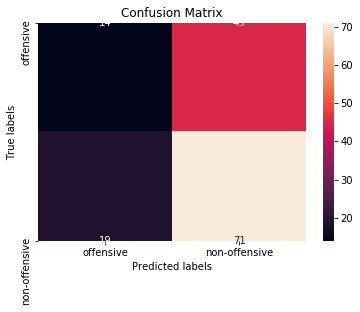

In [22]:
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_txt, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

In [27]:
# Loading pretrained image model from previous experiment
img_model = load_model('VGG16_img_model.h5')

W0819 19:57:44.541557  8196 deprecation_wrapper.py:119] From f:\anaconda\envs\exp_env\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [29]:
# Compiling model
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [30]:
# Concatenating the output
con_layer = keras.layers.concatenate([txt_model.output, img_model.output])
out = Dense(1,activation='sigmoid')(con_layer)

In [31]:
# Defining model input and output
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)

In [32]:
# Using Stochastic gradient descent with optimizer
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [33]:
# Plot the model
plot_model(com_model, to_file='BiLSTM_VGG_mul_model.png', show_shapes=True, show_layer_names=True)

In [34]:
# Training model
com_model.fit_generator(img_txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_txt_gen_val, shuffle=False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 259s 129s/step - loss: 0.7969 - acc: 0.4062 - val_loss: 0.6986 - val_acc: 0.4765
Epoch 2/7
2/2 [==============================] - 251s 125s/step - loss: 0.7927 - acc: 0.5156 - val_loss: 0.6956 - val_acc: 0.5302
Epoch 3/7
2/2 [==============================] - 252s 126s/step - loss: 0.8089 - acc: 0.4688 - val_loss: 0.6950 - val_acc: 0.4497
Epoch 4/7
2/2 [==============================] - 253s 127s/step - loss: 0.8190 - acc: 0.4531 - val_loss: 0.6943 - val_acc: 0.5034
Epoch 5/7
2/2 [==============================] - 244s 122s/step - loss: 0.7993 - acc: 0.5000 - val_loss: 0.6937 - val_acc: 0.5503
Epoch 6/7
2/2 [==============================] - 246s 123s/step - loss: 0.8074 - acc: 0.4844 - val_loss: 0.6953 - val_acc: 0.4966
Epoch 7/7
2/2 [==============================] - 251s 125s/step - loss: 0.8170 - acc: 0.6094 - val_loss: 0.6927 - val_acc: 0.5302


In [35]:
# Saving the text model
com_model.save('BiLSTM_VGG_mul_model.h5')

In [36]:
# Predicting the label using combined model
y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))

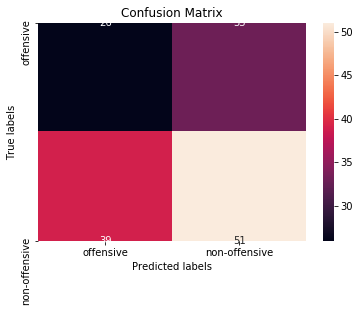

In [37]:
# Block for confusion matrix
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

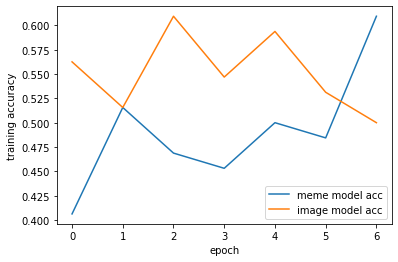

In [38]:
# training accuracy
plt.plot(com_model.history.epoch, com_model.history.history['acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['acc'])
plt.gca().legend(('meme model acc', 'image model acc', 'text model acc'))
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

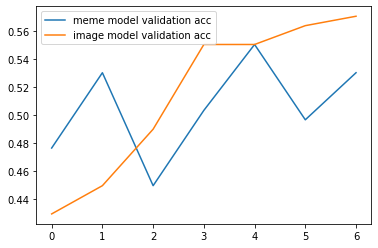

In [39]:
# Validation Accuracy
plt.plot(com_model.history.epoch, com_model.history.history['val_acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['val_acc'])
plt.gca().legend(('meme model validation acc', 'image model validation acc', 'text model validation acc'))
plt.show()

In [40]:
com_model.metrics_names

['loss', 'acc']

In [41]:
com_model.evaluate_generator(img_txt_gen_test, steps=5)

[0.706167459487915, 0.0]

In [42]:
img_model.evaluate_generator(img_gen_test, steps=5)

[0.024448825046420097, 1.0]

In [43]:
txt_model.evaluate_generator(txt_gen_test, steps=5)

[0.7561434626579284, 0.0]

In [44]:
from sklearn.metrics import precision_recall_fscore_support

In [45]:
# for txt
precision_recall_fscore_support(y_true, y_pred_txt, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.61206897, 0.42424242]),
 array([0.78888889, 0.23728814]),
 array([0.68932039, 0.30434783]),
 array([90, 59], dtype=int64))

In [46]:
# com model
precision_recall_fscore_support(y_true, y_pred_com, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.60714286, 0.4       ]),
 array([0.56666667, 0.44067797]),
 array([0.5862069 , 0.41935484]),
 array([90, 59], dtype=int64))